In [1]:
#Enable GPU use
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPus available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPus available:  1


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [3]:
with open('features.pk', 'rb') as handle:
    data = pickle.load(handle)
data = data.drop(columns=['MeetTijd','Length_MeetTijd','startTime','endTime'])

In [4]:
train, test = train_test_split(data, test_size=0.2)

In [5]:
X_train = train.drop(columns=['IcNaOk'])
y_train = train['IcNaOk']
X_test = test.drop(columns=['IcNaOk'])
y_test = test['IcNaOk']

In [6]:
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [7]:
model = tf.keras.Sequential([
    Dense(128, input_shape=(42,), activation='relu'), #second layer
    Dense(10, activation='relu'),
    Dense(2, activation='softmax') #gives probability of ICU admission
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5504      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 6,816
Trainable params: 6,816
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(x=X_train, y=y_train, batch_size=10, epochs=30, verbose=2, validation_split=0.1)

Epoch 1/30
441/441 - 3s - loss: 2927.3201 - accuracy: 0.7887 - val_loss: 435.8956 - val_accuracy: 0.8574
Epoch 2/30
441/441 - 1s - loss: 505.6045 - accuracy: 0.7939 - val_loss: 578.9573 - val_accuracy: 0.5499
Epoch 3/30
441/441 - 1s - loss: 392.1487 - accuracy: 0.7989 - val_loss: 247.6772 - val_accuracy: 0.7271
Epoch 4/30
441/441 - 1s - loss: 341.5103 - accuracy: 0.8066 - val_loss: 197.0181 - val_accuracy: 0.7251
Epoch 5/30
441/441 - 1s - loss: 273.6929 - accuracy: 0.8141 - val_loss: 427.6873 - val_accuracy: 0.9124
Epoch 6/30
441/441 - 1s - loss: 234.8607 - accuracy: 0.8134 - val_loss: 337.3264 - val_accuracy: 0.9104
Epoch 7/30
441/441 - 1s - loss: 248.8093 - accuracy: 0.8159 - val_loss: 133.9446 - val_accuracy: 0.8045
Epoch 8/30
441/441 - 1s - loss: 195.7085 - accuracy: 0.8132 - val_loss: 340.9613 - val_accuracy: 0.4481
Epoch 9/30
441/441 - 1s - loss: 157.5128 - accuracy: 0.8156 - val_loss: 91.0739 - val_accuracy: 0.8574
Epoch 10/30
441/441 - 1s - loss: 185.9908 - accuracy: 0.8222 - v

In [12]:
predictions = model.predict(x=X_test, batch_size=10,verbose=2)

123/123 - 0s


In [13]:
for i in predictions[1:10]:
    print(i)

[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1.000000e+00 5.051137e-23]
[3.1507355e-16 1.0000000e+00]


In [14]:
rounded_predictions = np.argmax(predictions,axis=-1)

In [15]:
rounded_predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [16]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [17]:
cm = confusion_matrix(y_true = y_test, y_pred=rounded_predictions)

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]

    print(cm)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
        horizontalalignment="center",
        color="white" if cm[i,j]>thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[984 105]
 [ 90  47]]


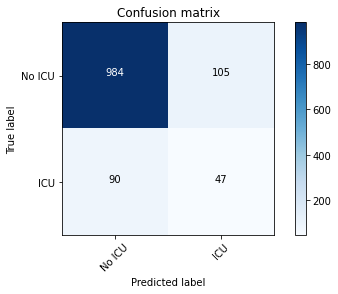

In [19]:
cm_plot_labels = ['No ICU','ICU']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion matrix')

array([1., 0., 1., ..., 0., 0., 1.], dtype=float32)

In [20]:
from sklearn.metrics import roc_curve
y_pred_keras = np.argmax(model.predict(X_test),axis=-1).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [21]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [22]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

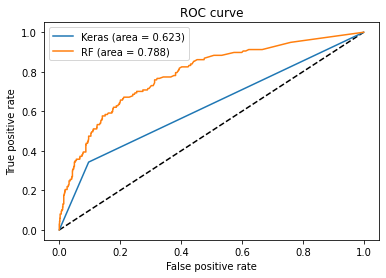

In [23]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

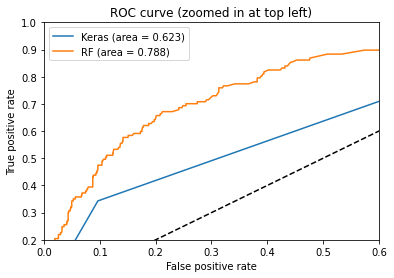

In [24]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.6)
plt.ylim(0.2, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()